# SVM Classifier

* ### Feature extraction

In [13]:
from skimage.io import imread
from skimage.feature import hog
from skimage.color import rgb2grey
import matplotlib.pyplot as plt
import numpy as np

In [14]:
def extract_features(img):
    color_features = img.flatten()
    grey_image = rgb2grey(img)
    hog_features = hog(grey_image, block_norm='L2-Hys')
    flat_features = np.hstack(color_features)
    return flat_features

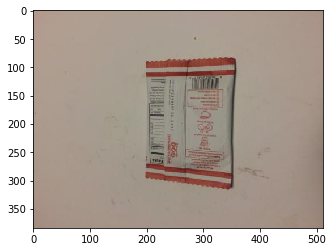

[178 151 140 ... 152 130 117]
(589824,)


In [16]:
# testing
test_img = imread("data/raw_data/resized/trash/trash123.jpg")
plt.imshow(test_img)
plt.show()
test_features = extract_features(test_img)
print(test_features)
print(test_features.shape)

There are too many features, need to use PCA to reduce dimensions

* ### Feature reduction

In [21]:
# single image testing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

print('original shape: ', test_features.shape)

# scaling
ss = StandardScaler()
ss_trans = ss.fit_transform(test_features.reshape(-1,1))

# PCA
pca = PCA()
pca_trans = ss.fit_transform(ss_trans)

# new shape
print('after transformation new shape is: ', pca_trans.shape)

original shape:  (589824,)
after transformation new shape is:  (589824, 1)
